# Second Competition: Modulation format classification

In [149]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

Load datasets. They are stored as a pickle file.

The datasets are taken from https://www.deepsig.io/datasets (RML2016.10a.tar.bz2), which contains a variety of radio datasets that are available as open datasets. The (simplified and modified, already pre-processed) dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received radio signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

In [150]:
# Load training dataset
with open('Deepsig_dataset_train.pkl', "rb") as f:
    X_train = pickle.load(f)
    y_train = pickle.load(f)
    SNR_train = pickle.load(f)
    modulation_formats = pickle.load(f)
    
# Load validation dataset
with open('Deepsig_dataset_valid.pkl', "rb") as f:
    X_valid = pickle.load(f)
    y_valid = pickle.load(f)
    SNR_valid = pickle.load(f)    

In [74]:
print(X_valid.shape)
print(SNR_train[0:100])
print((max(SNR_train)-min(SNR_train))/2)

(32000, 128)
[ -2   2 -10  16  12  -6  -6 -18   2  -4  -6   4 -20  -8   2 -10 -20  10
 -20  14   4  -2 -14  12  12   6   6   2   4  12  12  12 -12  18  18 -16
   8  16   8  -4 -10 -10  14 -14  12  -2   6 -10 -16   0   2  10   2   8
  12 -10  -4  -6  -4  16   8  10  16  -2 -10  18  -2  -6 -16  12 -20  -8
  -6   4 -12   6  16   8   6  -4  14   0  12  18  16  16   2   4 -18  14
 -16 -14  -4 -10 -20  -4   6 -18 -18 -10]
19.0


Print modulation formats that are used:

In [151]:
print('Modulation formats: ', modulation_formats)

Modulation formats:  ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

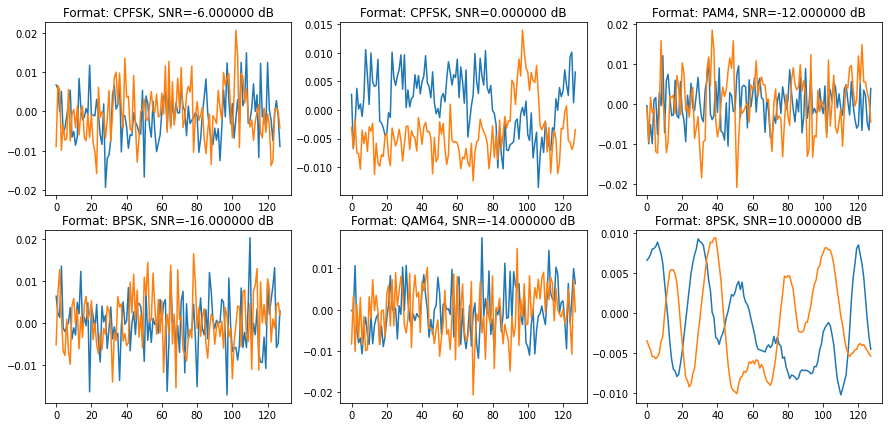

In [152]:
# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train[k+starti,:]))
    plt.plot(np.imag(X_train[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train[k+starti]], SNR_train[k+starti]))

## Task 1: Distinguish between BPSK and GFSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. Try the following two options:
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

Show the classification error for the validation set for each SNR point separately.

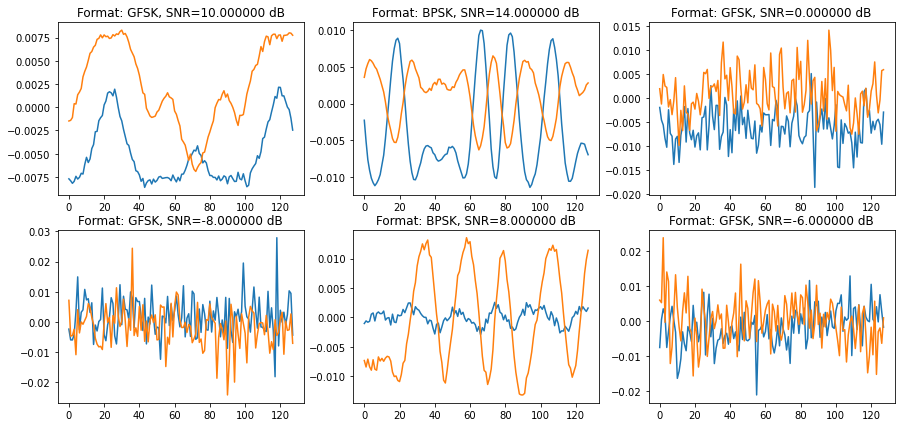

In [153]:
# generate Training set for Task 1
task1_modulation_formatidx = [i for i in range(len(modulation_formats)) if (modulation_formats[i] == 'BPSK' or modulation_formats[i] == 'GFSK')] 

task1_train_idx = [i for i in range(len(y_train)) if (y_train[i] == task1_modulation_formatidx[0] or y_train[i] == task1_modulation_formatidx[1])]
y_train_task1 = y_train[task1_train_idx]
X_train_task1 = X_train[task1_train_idx,:]
SNR_train_task1 = SNR_train[task1_train_idx]

task1_valid_idx = [i for i in range(len(y_valid)) if (y_valid[i] == task1_modulation_formatidx[0] or y_valid[i] == task1_modulation_formatidx[1])]
y_valid_task1 = y_valid[task1_valid_idx]
X_valid_task1 = X_valid[task1_valid_idx,:]
SNR_valid_task1 = SNR_valid[task1_valid_idx]

# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train_task1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task1[k+starti,:]))
    plt.plot(np.imag(X_train_task1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train_task1[k+starti]], SNR_train_task1[k+starti]))

In [157]:
def init_params(n_x,n_h,n_y):
    #initialize all the weights and bias
    W1 = np.random.rand(n_h,n_x)*np.sqrt(2/n_x)
    b1 = np.zeros((n_h,1))
    W2 = np.random.rand(n_y,n_h)*np.sqrt(2/n_h)
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,"b1": b1,"W2": W2,"b2": b2}
    
    return parameters

In [158]:
def forward_prop(X,params):
    #calculate forward propagation of the neural network model
    #retrieve parameters value
    W1 = params["W1"]
    W2 = params["W2"]
    b1 = params["b1"]
    b2 = params["b2"]
    #compute forward propagation
    Z1 = np.dot(W1,X)+b1     
    A1 = np.tanh(Z1)         #tanh activation function
    Z2 = np.dot(W2,A1)+b2
    A2 = 1/(1 + np.exp(-Z2)) #sigmoid activation function 
    #compute cache to be used in later gradient descent calculation
    cache = { "Z1" : Z1,"Z2" : Z2, "A1" : A1, "A2" : A2}
    return A2,cache

In [159]:
def compute_cost(A2,Y,params):
    #compute using cross entropy cost algorithm
    m = Y.shape[1]                  #number of examples
    logprobs = np.multiply(np.log(A2),Y) + np.multiply((1-Y),np.log(1-A2))
    cost = (-1/m)*np.sum(logprobs)
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
    assert(isinstance(cost, float)) # E.g., turns [[17]] into 17 
    
    return cost

In [160]:
def backward_prop(params,cache,X,Y):
    #compute the backward propagation
    m = X.shape[1]                #number of training examples
    #retrieve the parameters and cache value
    W1 = params["W1"]
    W2 = params["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    #calculate the backward propagation dw1,db1,dw2 and db2
    dZ2 = A2-Y
    dW2 = (1/m)*np.dot(dZ2,A1.transpose())
    db2 = (1/m)*np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = np.multiply(W2.transpose()*dZ2,(1-np.power(A1,2)))
    dW1 = (1/m)*np.dot(dZ1,X.transpose())
    db1 = (1/m)*np.sum(dZ1,axis=1,keepdims=True)
    #store in grads dictionary
    grads = {"dW1":dW1,"db1":db1,"dW2":dW2,"db2":db2}
    #return grads value
    return grads    

In [161]:
def update_params(params,grads,learning_rate):
    #update parameters
    #retrieve the parameters and grad value
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    #update for each parameters
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    #return parameters
    parameters = {"W1": W1,"b1": b1,"W2": W2,"b2": b2}
    return parameters

In [169]:
def Neural_Network_model(X,Y,n_H,alpha,num_iteration):    
    np.random.seed(3)                  #seed for random generator
    n_x = X.shape[0]                   #number of input layer
    #n_h = 512                          #number of hidden layer
    n_y = Y.shape[0]                   #number of output layer
    params = init_params(n_x,n_h,n_y)  #initialize parameter
    
    for i in range(0,num_iteration):
        #Forward Propagation
        A2,cache = forward_prop(X,params)
        #Cost Function
        cost = compute_cost(A2,Y,params)
        #Backpropagation
        grads = backward_prop(params,cache,X,Y)
        #Gradient Descent update
        params = update_params(params,grads,alpha)

        if i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    return params
    
    

#print(A2.shape)


In [170]:
#function to predict output from input and neural network parameters
def make_prediction(X,params):
    m = X.shape[1]
    p = np.zeros((1,m))
    A2,cache = forward_prop(X,params)
    
    for i in range(0,A2.shape[1]):
        if A2[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    return p
        

In [171]:
# helper function to compute the classification error rate
def CER(predictions, labels):
    return (np.sum(predictions != labels) / np.size(predictions))


In [192]:
# write your own classification algorithm here

#first shape the data, convert input data from 128 complex number to 256 real number
#from 128 features to 256 features
X     = np.concatenate((X_train_task1.real,X_train_task1.imag),axis=1).transpose()
X     = X /X.max()                  #normalize the input training X.max()
X_val = np.concatenate((X_valid_task1.real,X_valid_task1.imag),axis=1).transpose()
X_val = X_val/X_val.max()           #normalize the input validation

Y     = np.equal(y_train_task1,4)   #set 0 as BPSK and 1 as GFSK
Y     = Y.astype(float)             #convert data type to float
Y     = Y.reshape(-1,1).transpose() #reshape the array
Y_val = np.equal(y_valid_task1,4)
Y_val = Y_val.astype(float)
Y_val = Y_val.reshape(-1,1).transpose()

X_train_SNR=[]
X_valid_SNR=[]
Y_train_SNR=[]
Y_valid_SNR=[]

#variables
alpha = 0.5                       #learning rate  
num_iteration = 2500               #number of iteration
n_H = 32 #number of hidden layers

#divide the data base on SNR
SNR_range = np.unique(SNR_train_task1) #range of SNR from -20 to 18dB
Error_rates = np.zeros(len(SNR_range)) #store the value of error rate for every SNR
Error_rates_train = np.zeros(len(SNR_range))

#loop over all SNR value
for idx,value in enumerate(SNR_range[17:19]):
    #assign indices for every SNR value
    ids_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]
    ids_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    #divide data according to its SNR value
    X_train_SNR = X[:,ids_train]
    X_valid_SNR = X_val[:,ids_valid]
    Y_train_SNR = Y[:,ids_train]
    Y_valid_SNR = Y_val[:,ids_valid]
    
    #feed the data to Neural Network model
    params = Neural_Network_model(X_train_SNR,Y_train_SNR,n_H,alpha,num_iteration)
    #make a prediction    
    Y_pred_train = make_prediction(X_train_SNR,params)
    Y_pred = make_prediction(X_valid_SNR,params)    
    
    #calculate the error for every SNR value
    Error_rates_train[idx] = CER(Y_pred_train,Y_train_SNR)
    Error_rates[idx] = CER(Y_pred,Y_valid_SNR)
    
    
    print("Erorr rate for training set ,SNR "+str(value)+" dB = "+str(Error_rates_train[idx]))
    print("Error rate for validation set ,SNR "+str(value)+" dB = "+str(Error_rates[idx])) 
    '''
    print("X_val shape "+str(X_val.shape))
    print("length of ids_train "+str(len(ids_train)))
    print("length of ids_valid "+str(len(ids_valid)))
    print("X_train_SNR shape "+str(X_train_SNR.shape))
    print("Y_train_SNR shape "+str(Y_train_SNR.shape))
    print("Y_pred shape "+str(Y_pred.shape))
    print("X_valid_SNR "+str(X_valid_SNR.shape))
    print("Y_valid_SNR "+str(Y_valid_SNR.shape))      
    print("length of Y_pred "+str(np.size(Y_pred)))
    print("length of Y_valid_SNR "+str(np.size(Y_valid_SNR)))
    '''

Cost after iteration 0: 1.485007
Cost after iteration 100: 0.859772
Cost after iteration 200: 0.786159
Cost after iteration 300: 0.740818
Cost after iteration 400: 0.712301
Cost after iteration 500: 0.692475
Cost after iteration 600: 0.674561
Cost after iteration 700: 0.641725
Cost after iteration 800: 0.569568
Cost after iteration 900: 0.507383
Cost after iteration 1000: 0.471522
Cost after iteration 1100: 0.446618
Cost after iteration 1200: 0.410974
Cost after iteration 1300: 0.354165
Cost after iteration 1400: 0.300467
Cost after iteration 1500: 0.260995
Cost after iteration 1600: 0.229613
Cost after iteration 1700: 0.204012
Cost after iteration 1800: 0.184562
Cost after iteration 1900: 0.169824
Cost after iteration 2000: 0.157949
Cost after iteration 2100: 0.147697
Cost after iteration 2200: 0.138322
Cost after iteration 2300: 0.129357


KeyboardInterrupt: 

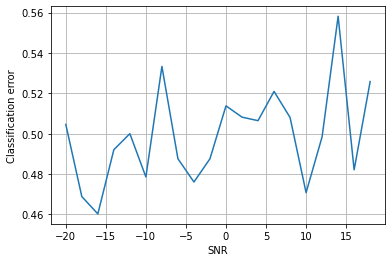

In [13]:


# prepare data, convert complex data to real and imaginary parts
X_train_real = np.column_stack((np.real(X_train_task1), np.imag(X_train_task1)))
X_valid_real = np.column_stack((np.real(X_valid_task1), np.imag(X_valid_task1)))


# generate 0/1 class labels
dic = {task1_modulation_formatidx[0]: 0, task1_modulation_formatidx[1]: 1}
y_train_mod = np.array([dic.get(i) for i in y_train_task1])
y_valid_mod = np.array([dic.get(i) for i in y_valid_task1])


SNR_range = np.unique(SNR_train_task1)
Error_rates = np.zeros(len(SNR_range))

# loop over SNRs
for idx, value in enumerate(SNR_range):
    # pick training and validation examples corresponding to specific SNR
    indices_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    indices_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]

    # dummy classifier ... return random numbers ... can you do betters?    
    valid_est = np.random.randint(low=0,high=2, size=y_valid_mod[indices_valid].shape)
   
    Error_rates[idx] = CER(valid_est, y_valid_mod[indices_valid])

plt.figure(figsize=(6,4))
plt.plot(SNR_range, Error_rates)
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

In [ ]:
# space where you can program your own (better) classifier






## Task 2: Classify modulation format
Design an ML system that estimates the modulation format from the traces (supervised learning, classification task). To evaluate the performance, carry out the classification separately for each SNR and show the performance for each SNR point.
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

## Task 2: Determine SNR
Determine the SNR from the examples (supervised learning, classification task)

## Task 3: Cluster the traces
Try if clustering is successful and if you can group examples that share similar properties (e.g., modulation format and SNR)